This notebook generates regional timeseries trend plots of annual number of fires (ANF) from AVHRR, and VPD based on the Jain et al (2021) VPD dataset (https://zenodo.org/records/5567062). 

Specifically:
* Figure 1 - inset plot (global trends timeseries)
* Figure 3 - VPD vs ANF trends for 6 interesting regions
* Figure S4 - extended materials plots for all GFED regions and biomes

In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

#custom
sys.path.append('./../../lib')
import paths as paths
import utils as utils

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def ts_plotter_vpd_flip(df, region_dict, ylab1, ylab2, xlab, av_color_list, fw_color_list, 
                   nrow, ncol, dim = None, ax2rm = None, xlabpad=0, sharex=False, vpd_dp=2):
    """ 
    func for plotting AVHRR vs. climate dual y-axis plots
    
    NOTE: there is redundant rounding going on here: both using np.round() and in string formatting
    this is a hangover from previous code iterations
    
    params:

    df: pandas dataframe, contains the fire count and vpd data to plot
    region_dict: dict, contains breakpoints for different regions (if applicable) 
    ylab1: str, left y axis label
    ylab2: str, right y axis label
    xlab: str, x axis label
    av_color_list: list, hex colours for plotting avhrr components
    fw_color_list: list, hex colours for plotting climate components
    nrow: int, dim of plot panels (n. rows) 
    ncol: int, dim of plot panels (n. columns)  
    dim: tuple of int, figure size. if None, defaults to (12,8)
    ax2rm: int, figure size. if not None, remove this many subaxes from the plot 
    xlabpad: float, pad the xaxis by this much 
    sharex: bool, share x axis, T or F? 
    vpd_dp; int, how many dp should climate be rounded to on the y-axis? default = 2
    
    returns:
    fig: figure object 
    axes: axes objects
    stats: df, summary stats 
    """
    
    eq_list = ['$\leq$', ' > ']
    
    if dim:
        pass
    else:
        dim=(12,8)      
    
    fig, axes = plt.subplots(figsize=dim, nrows=nrow, ncols=ncol,
                           squeeze=False, sharex=sharex,
                           gridspec_kw=dict(hspace=0.35, wspace=0.2))
    axes=axes.flatten()
    
    if ax2rm:   # delete excess axes
        for i in np.arange(ax2rm, 0):
            fig.delaxes(axes[i])
            
    statstable = pd.DataFrame({'region': [],'metric':[],
                           'year_start':[],'year_end' : [], 
                           'tau':[],'p':[],'intercept': [],
                           'slope':[],'lower':[],'upper':[],
                          })
    for i, (key, values) in enumerate(region_dict.items()):
        #print(i, key, values)
        ## if using all years of FW data ('df_outer'), need to remove the nans from matching AVHRR data to plot
        d_fw = df.loc[df.gfed_name==key].copy()
        d_av = df.loc[df.gfed_name==key].copy()    
        d_av = d_av.dropna()   

        x1 = d_fw['year'].values    
        y1 = d_fw['vpd_mean'].values
        y1n = d_fw['n_mean'].values

        x2 = d_av['year'].values        
        y2 = d_av['count'].values / 1000        
        y2n = d_av['ncount'].values
      
        ax1 = axes[i]
        ax2 = ax1.twinx()  # instantiate a second axes obj with same x-axis
        ax1.tick_params(axis='y', labelcolor=av_color_list[2])        
        ax2.tick_params(axis='y', labelcolor=fw_color_list[2])


        ### points & markers
        #FIRE WEATHER (blues)
        ax2.plot(x1, y1, marker='', ms=4, linestyle='-', color=fw_color_list[0], label=key, alpha=1, zorder=2)
        ax2.plot(x1, y1, marker='s', ms=4, linestyle='none', color=fw_color_list[1], label=key, alpha=1, zorder=2) #fe9929
        #AVHRR (oranges)
        ax1.plot(x2, y2, marker='', ms=4, linestyle='-', color=av_color_list[0], label=key, alpha=1, zorder=1) 
        ax1.plot(x2, y2, marker='o', ms=4, linestyle='none', color=av_color_list[1], label=key, alpha=1, zorder=2) #3690c0

        # first calc & store the 1986-2016 meteo stats 
        tau1, p1, slope1, intercept1, lower1, upper1 = utils.kendall_theilsen(x1, y1)        
        tau_n1, p_n1, slope_n1, intercept_n1, lower_n1, upper_n1 = utils.kendall_theilsen(x1, y1n)
        statstable.loc[len(statstable)] = [key, 'fireweather', x1[0], x1[-1], 
                         round(tau_n1,6), round(p_n1,6), round(intercept_n1,6), 
                         round(slope_n1,6), round(lower_n1,6), round(upper_n1,6)]    
        # first calc & store the 1986-2016 AVHRR stats      
        tau2, p2, slope2, intercept2, lower2, upper2 = utils.kendall_theilsen(x2, y2)
        tau_n2, p_n2, slope_n2, intercept_n2, lower_n2, upper_n2 = utils.kendall_theilsen(x2, y2n)   
        statstable.loc[len(statstable)] = [key, 'avhrr', x2[0], x2[-1], 
                       round(tau_n2,6), round(p_n2,6), round(intercept_n2,6), 
                       round(slope_n2,6), round(lower_n2,6), round(upper_n2,6)]    

        #PLOT TRENDS ###
        # AVHRR ============
        if values[0]: #i.e. have a change point
            # now do subdivided analysis        
            a = d_av.loc[d_av.year <= values[0]]
            b = d_av.loc[d_av.year >  values[0]]
            for k,dd in enumerate([a,b]):
                x = dd['year'].values        
                y = dd['count'].values / 1000
                yn = dd['ncount'].values
                txt_offset = k * 0.1
                # calc stats
                tau, p, slope, intercept, lower, upper = utils.kendall_theilsen(x, y)
                tau_n, p_n, slope_n, intercept_n, lower_n, upper_n = utils.kendall_theilsen(x, yn)            
                if p < 0.1:
                    ax1.plot(x, x * slope + intercept, av_color_list[2], linewidth=2, linestyle='-', zorder=1000)
                    if p < 0.001:
                        label=r'Fire {}{}: {:+.1f} % yr$^1$, p<0.001'.format(eq_list[k], values[0], np.round(slope_n * 100,1)) 
                    else:
                        label=r'Fire {}{}: {:+.1f} % yr$^1$, p={:.3f}'.format(eq_list[k], values[0], np.round(slope_n * 100,1), np.round(p_n,3)) 
                    plt.text(0.02, 0.9 - txt_offset, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)
                else:
                    label=r'Fire {}{}: no trend, p={:.3f}'.format(eq_list[k], values[0], p_n) 
                    plt.text(0.02, 0.9 - txt_offset, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)        
                # collate stats
                statstable.loc[len(statstable)] = [key, 'avhrr', x[0], x[-1], 
                                 round(tau_n,6), round(p_n,6), round(intercept_n,6), 
                                 round(slope_n,6), round(lower_n,6), round(upper_n,6)]
                #print('avhrr p-value:', d_av.gfed_full_name.values[0], p_n)
        else: #i.e. no change point
            if p2 < 0.1:
                ax1.plot(x2, x2 * slope2 + intercept2, av_color_list[2], linewidth=2, linestyle='-', zorder=1000)
                if p2 < 0.001:
                    label=r'Fire 1986-2016: {:+.1f} % yr$^1$, p<0.001'.format(np.round(slope_n2 * 100,1)) 
                else:            
                    label=r'Fire 1986-2016: {:+.1f} % yr$^1$, p={:.3f}'.format(np.round(slope_n2 * 100,1), np.round(p_n2,3)) 
                plt.text(0.02, 0.9, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)
            else:
                label=r'Fire 1986-2016: no trend, p={:.3f}'.format(np.round(p_n2,3)) 
                plt.text(0.02, 0.9, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)        
            #print('avhrr p-value:', d_av.gfed_full_name.values[0], p_n2)
        #  WEATHER ===========
        if values[1]:
            # now do subdivided analysis
            a = d_fw.loc[d_fw.year <= values[1]]
            b = d_fw.loc[d_fw.year >  values[1]]
            for k,dd in enumerate([a,b]):
                x = dd['year'].values        
                y = dd['vpd_mean'].values
                yn = dd['n_mean'].values

                txt_offset = k * 0.1
                # calc stats
                tau, p, slope, intercept, lower, upper = utils.kendall_theilsen(x, y)        
                tau_n, p_n, slope_n, intercept_n, lower_n, upper_n = utils.kendall_theilsen(x, yn)        

                if values[0]: # if AVHRRR has a change, change loc of meteo label
                    yloc=0.7 - txt_offset
                else:
                    yloc=0.8 - txt_offset

                if p < 0.1:
                    ax2.plot(x, x * slope + intercept, fw_color_list[2], linewidth=2, linestyle='-', zorder=1000)
                    if p < 0.001:
                        label=r'VPD {}{}: {:+.1f} % yr$^1$, p<0.001'.format(eq_list[k], values[1], np.round(slope_n * 100,1)) 
                    else:
                        label=r'VPD {}{}: {:+.1f} % yr$^1$, p={:.3f}'.format(eq_list[k], values[1], np.round(slope_n * 100,1), np.round(p_n,3)) 
                    plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax2.transAxes)
                else:
                    label=r'VPD {}{}: p={:.3f}'.format(eq_list[k], values[1], np.round(p_n,3)) 
                    label=r'VPD {}{}: no trend, p={:.3f}'.format(eq_list[k], values[1], np.round(p_n,3))                 
                    plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax2.transAxes)        
                # collate stats
                statstable.loc[len(statstable)] = [key, 'fireweather', x[0], x[-1], 
                                 round(tau_n,6), round(p_n,6), round(intercept_n,6), 
                                 round(slope_n,6), round(lower_n,6), round(upper_n,6)]
        else:
            txt_offset = 1 * 0.1
            if values[0]: # if AVHRRR has a change
                yloc=0.7
            else:
                yloc=0.9 - txt_offset        
            if p1 < 0.1:
                ax2.plot(x1, x1 * slope1 + intercept1, fw_color_list[2], linewidth=2, linestyle='-', zorder=1000)
                if p1 < 0.001:
                    label=r'VPD 1986-2016: {:+.1f} % yr$^1$, p<0.001'.format(np.round(slope_n1 * 100,1)) 
                else:
                    label=r'VPD 1986-2016: {:+.1f} % yr$^1$, p={:.3f}'.format(np.round(slope_n1 * 100,1), np.round(p_n1,3)) 
                plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax2.transAxes)
            else:
                label=r'VPD 1986-2016: p={:.3f}'.format(np.round(p_n1,3))
                label=r'VPD 1986-2016: no trend, p={:.3f}'.format(np.round(p_n1,3))
                plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax2.transAxes)        
        #print(d_fw.gfed_full_name.values[0], p_n1)
        
        # tidy up subplot
        ax1.set_title(d_av.gfed_full_name.values[0], fontsize=10)   
        # expand upper y limits for text
        ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1] * 1.1)
        ax2.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1] * 1.1) 
        ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter(f'%.{vpd_dp}f'))
        # adjust tick label font sizes
        ax1.tick_params(axis='both', which='major', labelsize=8)
        ax1.tick_params(axis='both', which='minor', labelsize=8)
        ax2.tick_params(axis='both', which='major', labelsize=8)
        ax2.tick_params(axis='both', which='minor', labelsize=8)
        
    # broad axis labels on dummy ax
    fig.add_subplot(111, frameon=False)
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax1.set_xlabel(xlab, color='k', fontsize=10, labelpad=xlabpad)
    ax1.set_ylabel(ylab2, color=av_color_list[2], fontsize=10, labelpad=0)    
    ax2.set_ylabel(ylab1, color=fw_color_list[2], fontsize=10)
    plt.box(False)
    ax1.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax2.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    return fig, axes, statstable

In [3]:
# colour palettes for plotting
av_color_list = ['#fec44f','#ec7014','#cc4c02'] #oranges  #fe9929
fw_color_list = ['#dcdcdc','#bdbdbd','#969696'] #greys

#params for figure set up
mm = 1/25.4

In [4]:
dir_base = Path(paths.dir_main)

dir_out_figures = dir_base / "outputs"

# avhrr regional total files
fp_avhrr_gfed = dir_base / "GFED_annual_counts_calendaryr.csv"
fp_avhrr_ttb = dir_base / "TempTropBoreal_annual_counts_calendaryr.csv"

#  VPD regional total files
fp_vpd_gfed = dir_base / "gfed_region_mean_vpd.csv"
fp_vpd_ttb = dir_base / "TemperateTropicalBoreal_region_mean_vpd.csv"

### 1) VPD - GFED regions
* make timeseries plots for fire counts (ANF) and VPD at GFED regional level
* Also does the Fig 1 inset plot (global) here

preprocess ANF

In [5]:
df = pd.read_csv(str(fp_avhrr_gfed))
df = df.loc[df.gfed_name!='Mask']

df.loc[df.gfed_name=='global', 'gfed_name'] = 'Global'

# normalise ANF to 1986
df86 = df.loc[df.year == 1986].rename(columns={'count':'count86'})
df = df.merge(df86[['gfed','gfed_name','count86']], how='left', 
              on=['gfed','gfed_name'])
df['ncount'] = df['count'] / df['count86']
df = df.drop('count86', axis=1)
print(df.head())
np.unique(df.gfed_name)

   sat_yr sat  year  gfed gfed_name  count  ncount
0  NF1986  NF  1986     1      BONA    237     1.0
1  NF1986  NF  1986     2      TENA    597     1.0
2  NF1986  NF  1986     3      CEAM    637     1.0
3  NF1986  NF  1986     4      NHSA    287     1.0
4  NF1986  NF  1986     5      SHSA   3224     1.0


array(['AUST', 'BOAS', 'BONA', 'CEAM', 'CEAS', 'EQAS', 'EURO', 'Global',
       'MIDE', 'NHAF', 'NHSA', 'SHAF', 'SHSA', 'SOAS', 'TENA'],
      dtype=object)

preprocess VPD

In [6]:
df_vpd_gfed = pd.read_csv(str(fp_vpd_gfed))

# ensemble mean values for 1986
vpd86 = df_vpd_gfed.loc[df_vpd_gfed.year == 1986].rename(columns={'vpd_mean':'mean86'})
#norm the ensemble stats
df_vpd_gfed = df_vpd_gfed.merge(vpd86[['gfed','gfed_name','mean86']],
                      how='left',
                      on=['gfed','gfed_name'])
df_vpd_gfed['n_mean'] = df_vpd_gfed['vpd_mean'] / df_vpd_gfed['mean86'] 

# drop unused
df_vpd_gfed = df_vpd_gfed.drop(['mean86'], axis=1)
df_vpd_gfed.head()

,gfed_name,gfed,year,vpd_mean,n_mean
0,BONA,1,1986,0.523740,1.000000
1,BONA,1,1987,0.570164,1.088639
2,BONA,1,1988,0.572142,1.092415
3,BONA,1,1989,0.558837,1.067012
4,BONA,1,1990,0.554619,1.058958


combine data

In [7]:
# combine AVHRR data with VPD data for GFED regions
df_outer = df_vpd_gfed.merge(df, how='outer', on=['year','gfed','gfed_name'])
df_inner = df_vpd_gfed.merge(df, how='inner', on=['year','gfed','gfed_name'])
df_inner.head()

#correct a typo in an earlier script
df_outer.loc[df_outer.gfed_name=='SEAS', 'gfed_name'] = 'SOAS'
df_inner.loc[df_inner.gfed_name=='SEAS', 'gfed_name'] = 'SOAS'

## used to calculate break points,  and also to plot boxplots (MS figure 4) of all 
## variables in 'change_point_identification.r' R Script
df_outer.to_csv(str(dir_base / 'avhrr_and_vpd_fulljoin_1986-2016.csv'),index=False)

In [8]:
# make more readable region names
df_outer['gfed_full_name'] = ''
df_outer.loc[df_outer.gfed_name=='BONA', 'gfed_full_name'] = 'Boreal North America (BONA)'
df_outer.loc[df_outer.gfed_name=='TENA', 'gfed_full_name'] = 'Temperate North America (TENA)'
df_outer.loc[df_outer.gfed_name=='CEAM', 'gfed_full_name'] = 'Central America (CEAM)'
df_outer.loc[df_outer.gfed_name=='NHSA', 'gfed_full_name'] = 'Northern Hemisphere South America (NHSA)'
df_outer.loc[df_outer.gfed_name=='SHSA', 'gfed_full_name'] = 'Southern Hemisphere South America (SHSA)'
df_outer.loc[df_outer.gfed_name=='EURO', 'gfed_full_name'] = 'Europe (EURO)'
df_outer.loc[df_outer.gfed_name=='MIDE', 'gfed_full_name'] = 'Middle East (MIDE)'
df_outer.loc[df_outer.gfed_name=='NHAF', 'gfed_full_name'] = 'Northern Hemisphere Africa (NHAF)'
df_outer.loc[df_outer.gfed_name=='SHAF', 'gfed_full_name'] = 'Southern Hemisphere Africa (SHAF)'
df_outer.loc[df_outer.gfed_name=='BOAS', 'gfed_full_name'] = 'Boreal Asia (BOAS)'
df_outer.loc[df_outer.gfed_name=='CEAS', 'gfed_full_name'] = 'Central Asia (CEAS)'
df_outer.loc[df_outer.gfed_name=='SOAS', 'gfed_full_name'] = 'Southern Asia (SOAS)'
df_outer.loc[df_outer.gfed_name=='EQAS', 'gfed_full_name'] = 'Equatorial Asia (EQAS)'
df_outer.loc[df_outer.gfed_name=='AUST', 'gfed_full_name'] = 'Australasia (AUST)'
df_outer.loc[df_outer.gfed_name=='Global', 'gfed_full_name'] = 'Global'

df_outer.head()
print(df_outer.gfed_full_name.unique())

['Boreal North America (BONA)' 'Temperate North America (TENA)'
 'Central America (CEAM)' 'Northern Hemisphere South America (NHSA)'
 'Southern Hemisphere South America (SHSA)' 'Europe (EURO)'
 'Middle East (MIDE)' 'Northern Hemisphere Africa (NHAF)'
 'Southern Hemisphere Africa (SHAF)' 'Boreal Asia (BOAS)'
 'Central Asia (CEAS)' 'Southern Asia (SOAS)' 'Equatorial Asia (EQAS)'
 'Australasia (AUST)' 'Global']


Figure 1 (Inset): make a global plot 

* This is generated using a 'hack' to maintain the same aspect ratio as the regional plots in Figure 2, get this by generating a 2*3 plot and just deleting the last 5 axes

C:\Users\mdejong\AppData\Local\Temp\ipykernel_16860\1765866110.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


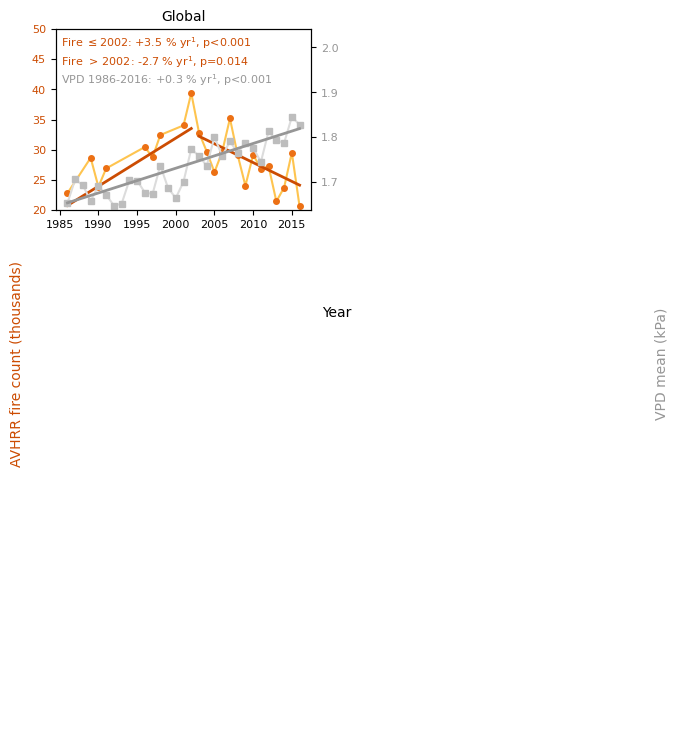

In [9]:
region_dict = {'Global':[2002, None]}

fig, axes, stats_tbl = ts_plotter_vpd_flip(df=df_outer, region_dict=region_dict, 
                           ylab1="VPD mean (kPa)",
                           ylab2="AVHRR fire count (thousands)",
                           xlab="Year", 
                           av_color_list=av_color_list, fw_color_list=fw_color_list, 
                            nrow=3, ncol=2, dim = (175*mm,185*mm), xlabpad=-300, vpd_dp=1) 
axes[0].set_ylim([20,50])
fig.tight_layout()
for i in np.arange(-5,0):
    fig.delaxes(axes[i])

fig.savefig(str(dir_out_figures / '01_INSET_timeseries_gfed_vpd_global_flip.png'), dpi=1000)
fig.savefig(str(dir_out_figures / '01_INSET_timeseries_gfed_vpd_global_flip.pdf'))

Figure 3) ANF and VPD trends by region for 6 interesting regions

C:\Users\mdejong\AppData\Local\Temp\ipykernel_16860\3826944281.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


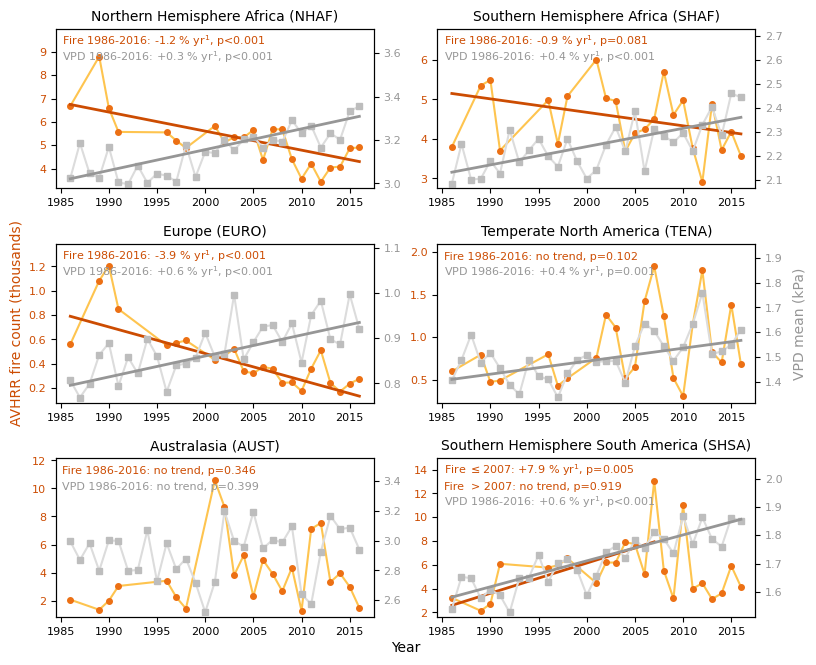

In [10]:
region_dict = {
    #'global':[2002, None],                
    'NHAF':  [None, None], #fw=2005?
    'SHAF':  [None, None],           
    'EURO':  [None, None],
    'TENA':  [None, None],
    'AUST':  [None, None],
    'SHSA':  [2007, None]
              }

fig, axes, stats_tbl = ts_plotter_vpd_flip(df=df_outer, region_dict=region_dict, 
                           ylab1="VPD mean (kPa)",
                           ylab2="AVHRR fire count (thousands)",
                           xlab="Year", 
                           av_color_list=av_color_list, fw_color_list=fw_color_list, 
                            nrow=3, ncol=2, dim = (210*mm,168*mm), vpd_dp=1)  # 10x8=8/10=0.8 ratio, 210*0.8=168mm
fig.tight_layout()

#fig.savefig(os.path.join(dir_out, f'02_GFED_timeseries_avhrr_VPD_with_trends_SUBSET_v2_scaledREVISED.png'), dpi=800)
fig.savefig(str(dir_out_figures / '03_timeseries_gfed_vpd_subset_flip.png'), dpi=1000)
fig.savefig(str(dir_out_figures / '03_timeseries_gfed_vpd_subset_flip.pdf'))
#statstable
stats_tbl.to_csv(str(dir_out_figures / '03_timeseries_gfed_vpd_subset_flip.csv'),index=False)

Extended Data Figure 4). Plot ALL GFED regions for side by side comparison

C:\Users\mdejong\AppData\Local\Temp\ipykernel_16860\568047162.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


   region       metric  year_start  year_end       tau         p   intercept     slope     lower     upper
0    BONA  fireweather        1986      2016  0.182796  0.154529   -2.350383  0.001706 -0.000420  0.004238
1    BONA        avhrr        1986      2016  0.067194  0.676022  -41.360376  0.021672 -0.069198  0.099916
2    TENA  fireweather        1986      2016  0.406452  0.001076   -6.420632  0.003738  0.001392  0.006334
3    TENA        avhrr        1986      2016  0.249012  0.101926  -43.629287  0.022393 -0.007087  0.066164
4    CEAM  fireweather        1986      2016  0.384946  0.002036   -5.621697  0.003356  0.001522  0.005204
5    CEAM        avhrr        1986      2016 -0.169960  0.270670   26.505495 -0.012873 -0.029399  0.011338
6    CEAM  fireweather        1986      1998  0.564103  0.006677  -17.794369  0.009456  0.004884  0.015929
7    CEAM  fireweather        1999      2016 -0.071895  0.708881    2.252353 -0.000568 -0.002876  0.002866
8    NHSA  fireweather        1986   

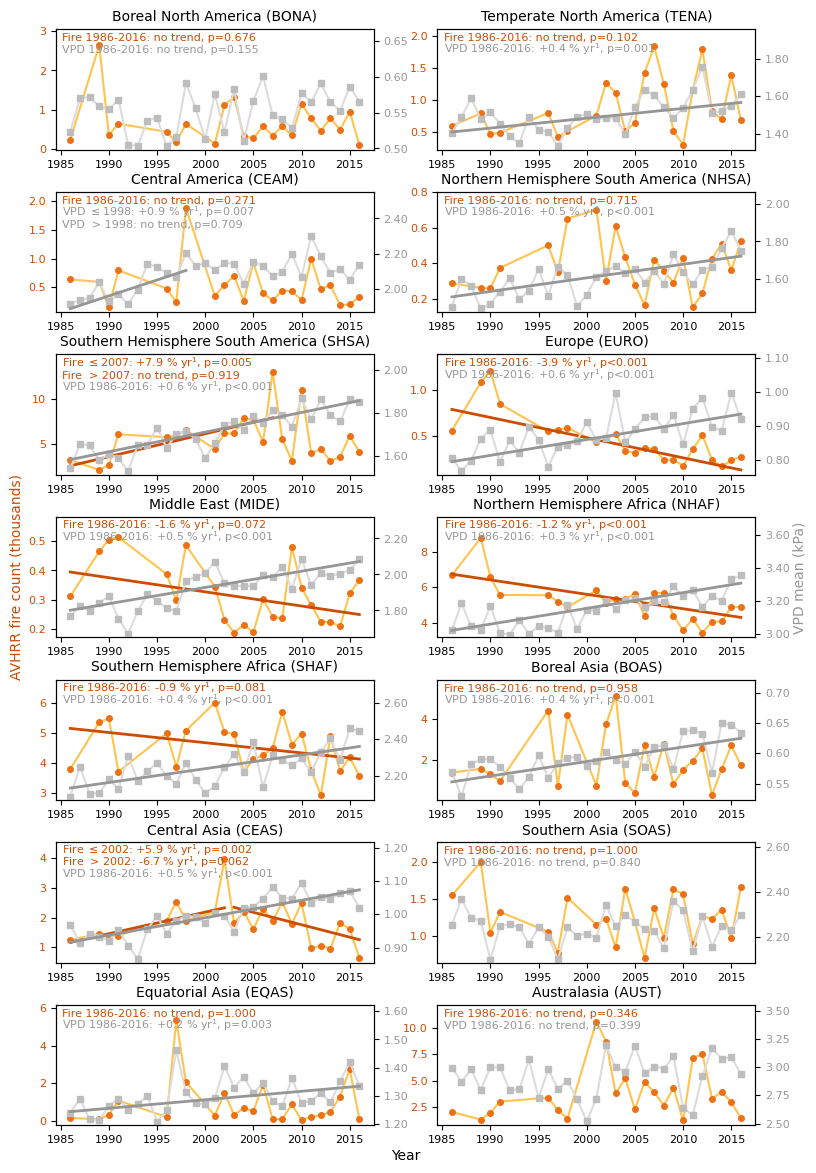

In [11]:
region_dict = {'BONA':  [None, None],
               'TENA':  [None, None], 
               'CEAM':  [None, 1998], 
               'NHSA':  [None, None],  
               'SHSA':  [2007, None],
               'EURO':  [None, None],
               'MIDE':  [None, None],
               'NHAF':  [None, None],
               'SHAF':  [None, None],
               'BOAS':  [None, None],
               'CEAS':  [2002, None], 
               'SOAS':  [None, None], 
               'EQAS':  [None, None],
               'AUST':  [None, None]
              }


fig, axes, stats_tbl = ts_plotter_vpd_flip(df=df_outer, region_dict=region_dict, 
                           ylab1="VPD mean (kPa)",
                           ylab2="AVHRR fire count (thousands)",
                           xlab="Year", 
                           av_color_list=av_color_list, fw_color_list=fw_color_list, 
                            nrow=7, ncol=2, dim = (210*mm,297*mm))
fig.tight_layout()

#figs
fig.savefig(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.png'), dpi=1000)
fig.savefig(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.pdf'))

#statstable
stats_tbl.to_csv(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.csv'),index=False)
print(stats_tbl)

### 2) VPD - biome regions
* make timeseries plots for fire counts (ANF) and VPD at Biome (temp/trop/boreal) level

In [12]:
# preprocess avhrr
df_ttb = pd.read_csv(str(fp_avhrr_ttb))
# make global and append
globe = df_ttb.groupby(['sat_yr', 'sat', 'year'])['count'].agg(['sum']).rename(columns={'sum':'count'}).reset_index()
globe['tropflag'] = 'Global'
df_ttb = pd.concat([df_ttb, globe])
# normalise to 1986
df86 = df_ttb.loc[df_ttb.year == 1986].rename(columns={'count':'count86'})
df_ttb = df_ttb.merge(df86[['tropflag','count86']], how='left', 
              on=['tropflag'])
df_ttb['ncount'] = df_ttb['count'] / df_ttb['count86']
df_ttb = df_ttb.drop('count86', axis=1)
df_ttb = df_ttb.rename(columns={'tropflag':'ttb_name'})
df_ttb.head()

,sat_yr,sat,year,ttb_name,count,ncount
0,NF1986,NF,1986,Boreal,1871,1.000000
1,NF1986,NF,1986,Temperate,6569,1.000000
2,NF1986,NF,1986,Tropics,14338,1.000000
3,NH1989,NH,1989,Boreal,4879,2.607696
4,NH1989,NH,1989,Temperate,8089,1.231390


In [13]:
# preprocess fire weather
df_vpd_ttb = pd.read_csv(str(fp_vpd_ttb))
print(np.unique(df_vpd_ttb.ttb))
vpd86_ttb = df_vpd_ttb.loc[df_vpd_ttb.year == 1986].rename(columns={'vpd_mean':'vpd_mean86'})
df_vpd_ttb = df_vpd_ttb.merge(vpd86_ttb[['ttb','ttb_name','vpd_mean86']],
                        how='left', on=['ttb','ttb_name'])
df_vpd_ttb['nvpd_mean'] = df_vpd_ttb['vpd_mean'] / df_vpd_ttb['vpd_mean86']
df_vpd_ttb = df_vpd_ttb.drop(['vpd_mean86'], axis=1)
df_vpd_ttb.head()
np.unique(df_vpd_ttb.ttb_name)

[ 1  2  3 99]


array(['Boreal', 'Global', 'Temperate', 'Tropics'], dtype=object)

In [14]:
# combine
df_outer = df_vpd_ttb.merge(df_ttb, how='outer', on=['year','ttb_name'])
df_inner = df_vpd_ttb.merge(df_ttb, how='inner', on=['year','ttb_name'])
df_inner.head()
df_outer.head()

# use this file in R to get break points!
df_outer.to_csv(str(dir_base / 'avhrr_and_vpd_fulljoin_1986-2016_TropTempBoreal.csv'), index=False)

plot biome data

In [15]:
# the plotting function is built for gfed regions and not very flexible; 
# so temporarily rename some cols

df_outer2 = df_outer.copy()
df_outer2 = df_outer2.rename(columns={'ttb_name': 'gfed_name', 
                         'ttb': 'gfed' ,
                         'nvpd_mean': 'n_mean'}) 
df_outer2['gfed_full_name'] = df_outer2['gfed_name']

C:\Users\mdejong\AppData\Local\Temp\ipykernel_16860\3416119241.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


,region,metric,year_start,year_end,tau,p,intercept,slope,lower,upper
0,Tropics,fireweather,1986,2016,0.655914,0.000000,-5.893272,0.003478,0.002651,0.004395
1,Tropics,avhrr,1986,2016,-0.177866,0.248285,11.585873,-0.005192,-0.020235,0.005603
2,Temperate,fireweather,1986,2016,0.565591,0.000002,-5.132530,0.003081,0.002042,0.004150
3,Temperate,avhrr,1986,2016,-0.051383,0.754031,6.140455,-0.002489,-0.019167,0.013504
4,Boreal,fireweather,1986,2016,0.556989,0.000004,-7.665601,0.004359,0.002898,0.006316
5,Boreal,avhrr,1986,2016,-0.083004,0.601269,28.542016,-0.013599,-0.057990,0.040299
6,Global,fireweather,1986,2016,0.630108,0.000000,-5.613852,0.003330,0.002594,0.004162
7,Global,avhrr,1986,2016,-0.162055,0.294366,12.418243,-0.005565,-0.021622,0.004398
8,Global,avhrr,1986,2002,0.833333,0.000854,-68.708984,0.035055,0.019664,0.056868
9,Global,avhrr,2003,2016,-0.494505,0.013838,56.267471,-0.027385,-0.050145,-0.004024


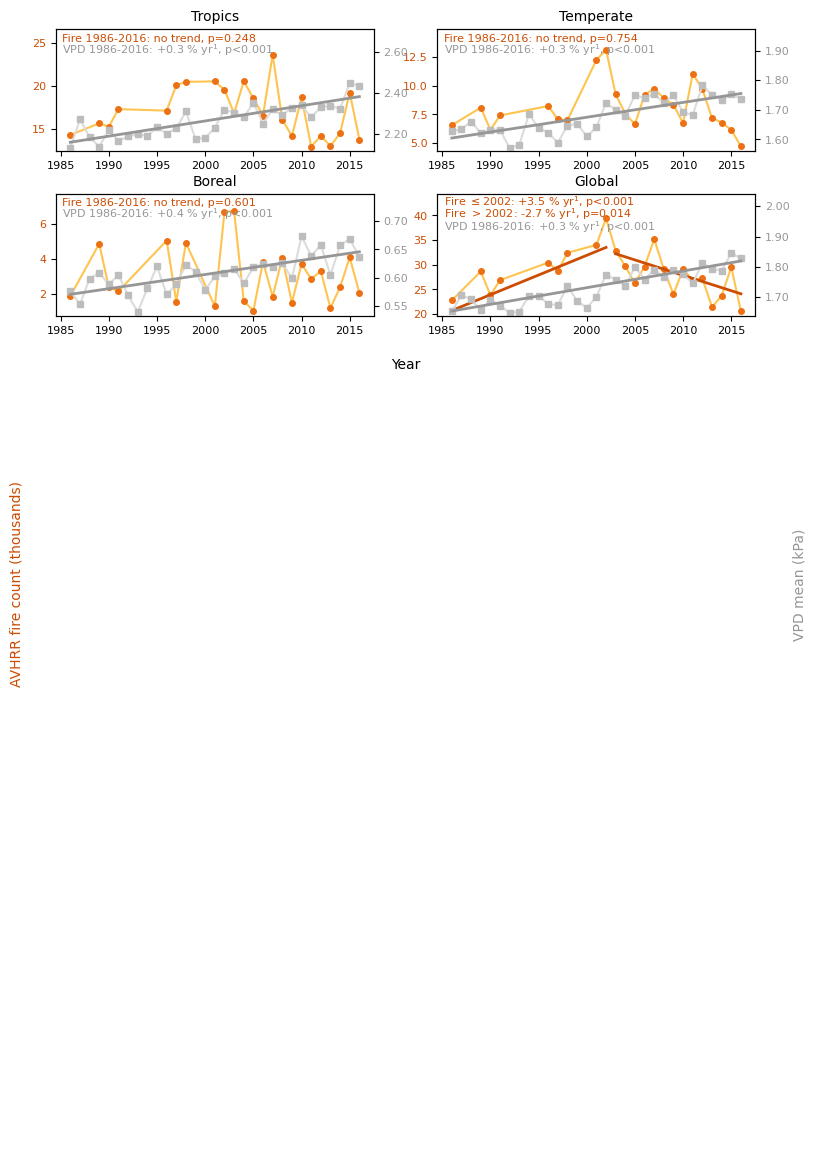

In [16]:
region_dict = {'Tropics':    [None, None],
               'Temperate':  [None, None],                
               'Boreal':     [None, None],
               'Global':     [2002, None]
               }

fig, axes, stats_tbl = ts_plotter_vpd_flip(df=df_outer2, region_dict=region_dict, 
                           ylab1="VPD mean (kPa)",
                           ylab2="AVHRR fire count (thousands)",
                           xlab="Year", 
                           av_color_list=av_color_list, fw_color_list=fw_color_list, 
                            nrow=7, ncol=2, dim = (210*mm,297*mm), ax2rm=-0, xlabpad=-580)
fig.tight_layout()
for i in np.arange(-10,0):
    fig.delaxes(axes[i])

#figs
fig.savefig(str(dir_out_figures / 's4_timeseries_TTB_vpd_flip.png'), dpi=1000)
#fig.savefig(os.path.join(dir_out_figures, 's4_timeseries_TTB_vpd_flip.pdf'))

#statstable
stats_tbl.to_csv(str(dir_out_figures / 's4_timeseries_TTB_vpd_flip.csv'), index=False)

stats_tbl